# Logistic Regression 

Applied to Youtube Comments for Spam Classification

In [1]:
#Algorithm 1 - Logistic Regression

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import math
from operator import mul
import random
import seaborn as sns

#Scikit.learn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

#NLTK Packages
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import words, stopwords
from nltk.text import Text
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

nltk.download('stopwords')
stop_words = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shaun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Importing the dataset by combining CSV files
comment_data = []
files = ['Youtube01-Psy.csv', 'Youtube02-KatyPerry.csv', 'Youtube03-LMFAO.csv', 'Youtube04-Eminem.csv', 'Youtube05-Shakira.csv']
for file in files:
    file_data = pd.read_csv(file)
    comment_data.append(file_data)
comment_data = pd.concat(comment_data)

#Looking at data
comment_data.info()
comment_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 5 columns):
COMMENT_ID    1956 non-null object
AUTHOR        1956 non-null object
DATE          1711 non-null object
CONTENT       1956 non-null object
CLASS         1956 non-null int64
dtypes: int64(1), object(4)
memory usage: 91.7+ KB


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [3]:
#Counting numbers of positives and negatives
comment_data['CLASS'].value_counts()

1    1005
0     951
Name: CLASS, dtype: int64

This shows an even distribution of spam and "ham"(not spam)

In [4]:
#Removing extra features
def remove_excess_features (features, dataset):
    dataset.drop(features, axis=1, inplace=True)

#Assuming we do not need Author, Commend_Id, and date?
remove_excess_features(['AUTHOR', 'COMMENT_ID', 'DATE'], comment_data)

comment_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 2 columns):
CONTENT    1956 non-null object
CLASS      1956 non-null int64
dtypes: int64(1), object(1)
memory usage: 45.8+ KB


# Text Cleanup
Here we will a) remove all non printable characters b) tokenize the phrases into words c) remove stopwords

In [5]:
#Removing all non-printable characters
printable = set(string.printable)
comment_data['CLEANED_CONTENT'] = comment_data['CONTENT'].apply(lambda x: ''.join([" " if i not in printable else i for i in x]))

#Apply Tokenization
import re
def wordize_column(comment):
    return " ".join(re.findall("[A-Za-z]+",comment.lower()))
comment_data["WORDIZED_CONTENT"] = comment_data['CLEANED_CONTENT'].apply(wordize_column)

#Remove used content columns
final_comment_data = comment_data.drop(["CONTENT", "CLEANED_CONTENT"], axis=1)

#Removing stopwords
def remove_stopwords(comment):
    commentwords = word_tokenize(comment)
    resultwords = [word for word in commentwords if not word in stop_words]
    result = ' '.join(resultwords)
    return result

#Iterate over dataframe
final_comment_data["NO_STOP_CONTENT"] = final_comment_data["WORDIZED_CONTENT"].map(remove_stopwords)
df = final_comment_data.drop(["WORDIZED_CONTENT"],axis=1)

df.head(n=20)

,CLASS,NO_STOP_CONTENT
0,1,huh anyway check tube channel kobyoshi
1,1,hey guys check new channel first vid us monkey...
2,1,test say murdev com
3,1,shaking sexy ass channel enjoy
4,1,watch v vtarggvgtwq check
5,1,hey check new website site kids stuff kidsmedi...
6,1,subscribe channel
7,0,turned mute soon came wanted check views
8,1,check channel funny videos
9,1,u check channel tell next


# Stemming

Porter Stemmer is the least aggressive stemming algorithm. Snowball Stemmer or Porter II is slightly more aggressive, whilst retaining semantic value in the words. The Lancaster stemmer is the most aggressive, sometimes removing the majority of the original word. The fourth option is not to apply stemming at all, and compare all 4 methods.

In [6]:
#Stemming content column

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

#Using Porter Stemmer -- Option A
# stemmer = PorterStemmer()

# # Using Snowball Stemmer -- Option B
# stemmer = SnowballStemmer("english")

# using Lancaster Stemmer -- Option C
stemmer = LancasterStemmer()

#using no Stemmer -- Option D
# def stem_sentences(sentence):
#     return sentence

df['STEMMED_CONTENT'] = df['NO_STOP_CONTENT'].apply(stem_sentences)
df = df.drop(['NO_STOP_CONTENT'],axis=1)

df.head(n=20)

,CLASS,STEMMED_CONTENT
0,1,huh anyway check tub channel kobyosh
1,1,hey guy check new channel first vid us monkey ...
2,1,test say murdev com
3,1,shak sexy ass channel enjoy
4,1,watch v vtarggvgtwq check
5,1,hey check new websit sit kid stuff kidsmediaus...
6,1,subscrib channel
7,0,turn mut soon cam want check view
8,1,check channel funny video
9,1,u check channel tel next


Next we apply count vectorizer and TFIDF transformer (combined under TfidfVectorizer) to the dataset. This will convert a collection of raw documents to a matrix of TF-IDF features. We also have the option to apply ngram range. We will keep unigrams to start with.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['STEMMED_CONTENT'])
y = df['CLASS'].reset_index(drop=True)

#Creating dataframe for use with k-folds cross validation
df1 = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names())
df2 = df['CLASS'].reset_index(drop=True)
# print(df2)
new_df = df1.merge(df2,left_index=True, right_index=True)

Visualizing the vocabulary related to spam, and that related to ham.

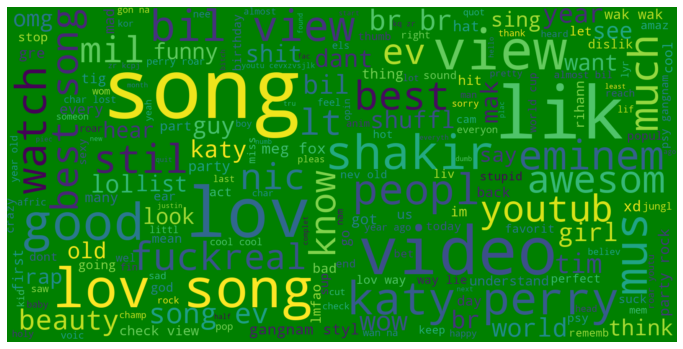

In [8]:
#Visualising "spam" vs "not spam" vocabulary
from wordcloud import WordCloud

#Ham
ham = df[df['CLASS'] == 0]
ham_string = []
for t in ham.STEMMED_CONTENT:
    ham_string.append(t)
ham_string = pd.Series(ham_string).str.cat(sep=' ')    

#Wordcloud for not spam comments
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color="green").generate(ham_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

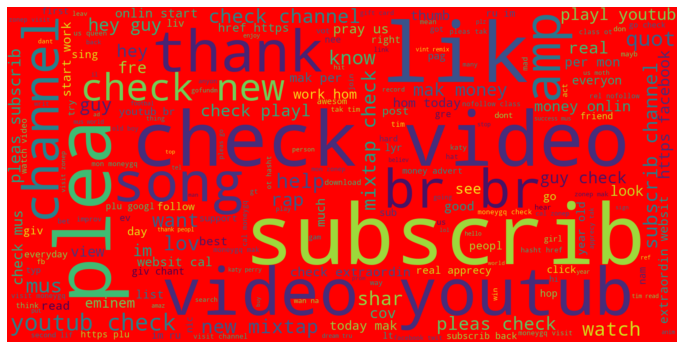

In [9]:
#Spam
spam = df[df['CLASS'] == 1]
spam_string = []
for t in spam.STEMMED_CONTENT:
    spam_string.append(t)
spam_string = pd.Series(spam_string).str.cat(sep=' ')    

#Wordcloud for spam comments
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color="red").generate(spam_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Using Sklearn to apply Logistic Regression

First the package-optimized method will be applied to the data.

In [28]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

(1564, 3287)

In [11]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver = 'lbfgs', random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

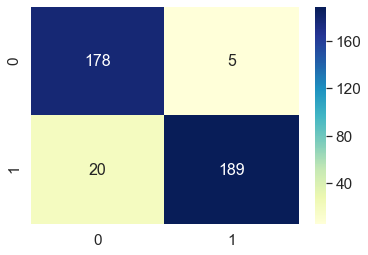

In [12]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

'''Plotting a confusion matrix as follows:
[True negative, False Positive
 False Negative, True Positive]'''

#Building the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt="d",  cmap="YlGnBu") # font size

plt.show()

----------------------------------------------------------------------
Logistic Regression Accuracy(Sklearn): 0.9362244897959183
----------------------------------------------------------------------
Logistic Regression F1(Sklearn): 0.9379652605459056
----------------------------------------------------------------------
Logistic Regression Precision(Sklearn): 0.9742268041237113
----------------------------------------------------------------------
Logistic Regression Recall(Sklearn): 0.9043062200956937
----------------------------------------------------------------------


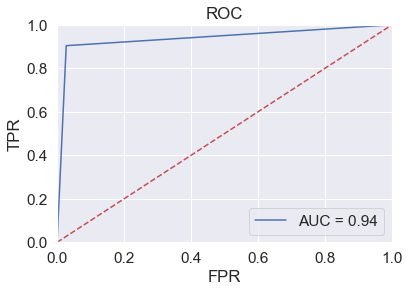

In [13]:
#Gauging performance using Sklearn metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve

print("----------------------------------------------------------------------")
print("Logistic Regression Accuracy(Sklearn):",accuracy_score(y_test, y_pred))
print("----------------------------------------------------------------------")
print("Logistic Regression F1(Sklearn):",f1_score(y_test, y_pred))
print("----------------------------------------------------------------------")
print("Logistic Regression Precision(Sklearn):",precision_score(y_test, y_pred))
print("----------------------------------------------------------------------")
print("Logistic Regression Recall(Sklearn):",recall_score(y_test, y_pred))
print("----------------------------------------------------------------------")

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'best')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()


# Building Logistic Regression from scratch

Our own model will be built at this point

In [14]:
#Changing from sparse array to np matrix for use with sigmoid function
X = np.matrix(X.toarray())
y = np.asarray(y)

#Feature Scaling (even though when attempted, this resulted in no difference in the result whatsoever)
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Applying PCA

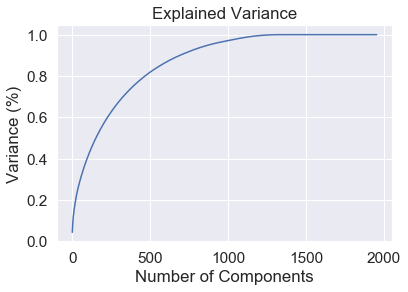

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = [0, 1])
df_rescaled = scaler.fit_transform(new_df.iloc[1:,0:-1])

#Fitting the PCA algorithm with our Data
pca = PCA().fit(df_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

#Result shows 1250 components

In [16]:
pca = PCA(n_components = 1250)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_

Logistic sigmoid Function outputs the conditional probabilities of the prediction.

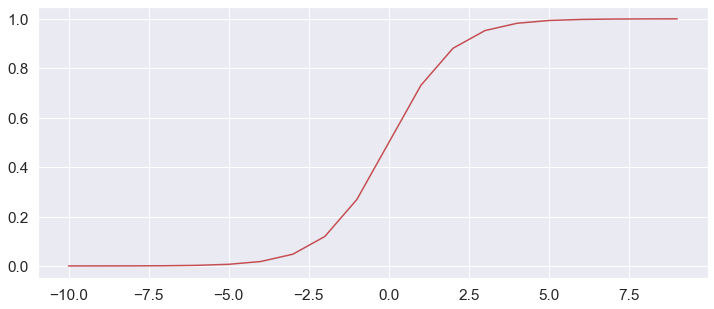

In [17]:
#Sigmoid Function
def sigmoid(z):
    result = 1 / (np.exp(-z) + 1)
    return result

#Visualise Sigmoid
numbers = np.arange(-10, 10, step=1)
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(numbers, sigmoid(numbers), 'r')
plt.show()

Building the gradient descent model through the cost function and the calculation of the respective gradients

In [18]:
#Initialisation of weights in the equation, where w is the matrix of x-coefficients and c is the y-intercept
def initial_weights(num_of_features):
    w = np.zeros((1, num_of_features))
    c = 0
    return w, c

Optimisation of Model which takes either the initialised weights if just starting the algorithm, or the updated weights through another model prediction function, and the independent and dependent variables.

In [19]:
def optimisation_of_model(w, c, X, y):
    m = X.shape[0]
    
    #predicting result
    pred_result = (np.dot(w, X.T) + c)
    pred_final_result = np.asarray(sigmoid(pred_result))
    #y.T is the actual result, to be compared with the output from final_result

    #Cost Function
    cost = (-1/m)*(np.sum((y.T*np.log(pred_final_result)) + ((1-y.T)*(np.log(1-pred_final_result)))))
    
    #Calculate the current gradients
    w_gradient = (np.dot(X.T, (pred_final_result - y.T).transpose())) / m
    c_gradient = (np.sum(pred_final_result - y.T)) / m

    return w_gradient, c_gradient, cost

Model prediction function, which takes the independent and dependent variables, learning rate alpha, and the number of iterations it is to be repeated for

In [20]:
def prediction_model(w, c, X, y, alpha, num_of_iter, iter_gap):
    #initialise costs as zero
    costs = []
  
    for i in range(num_of_iter):
        w_gradient, c_gradient, cost = optimisation_of_model(w, c, X, y)
        
        #Update Weights
        w = w - (alpha * (w_gradient.T))
        c = c - (alpha * c_gradient)
        
        if (i % iter_gap == 0):
            costs.append(cost)
            print("-----------------------------------")
            print("After {} iterations, cost is {}.".format(i, cost))
    
    #End parameters for model
    end_param = {"x-coefficients": w, "y-intercept" : c, "w_gradient" : w_gradient, "c_gradient" : c_gradient }
    
    return end_param, costs, iter_gap

The following takes the result of the sigmoid and classifies as 0 or 1

In [21]:
def predict(final_pred, m):
    y_pred = np.zeros((1,m))
    for i in range (final_pred.shape[1]):
        if final_pred[0][i] > 0.5:
            y_pred[0][i] = 1
    return y_pred

# Running the algorithm

In [22]:
#Initialising weights
w,c = initial_weights(X_train.shape[1])

In [24]:
#Start Gradient Descent

'''WARNING, THIS OUTPUT WILL BE LONG(DEPENDING ON iter_gap) AND THE PROCESS MAY TAKE LONG. 
REDUCE num_of_iter or INCREASE iter_gap accordingly'''

end_param, costs, iter_gap = prediction_model(w, c, X_train, y_train, alpha = 0.001, num_of_iter = 16000, iter_gap = 2000)

-----------------------------------
After 0 iterations, cost is 0.6931471805599452.
-----------------------------------
After 2000 iterations, cost is 0.19480563091868702.
-----------------------------------
After 4000 iterations, cost is 0.1202598413523091.
-----------------------------------
After 6000 iterations, cost is 0.08929911100717206.
-----------------------------------
After 8000 iterations, cost is 0.07210641990124195.
-----------------------------------
After 10000 iterations, cost is 0.06107360665242409.
-----------------------------------
After 12000 iterations, cost is 0.05334919505229342.
-----------------------------------
After 14000 iterations, cost is 0.047615590944448276.


In [ ]:
#Plotting cost against iterations
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per {})'.format(iter_gap))
plt.title('Cost reduction over time')
plt.show()

In [25]:
#Final prediction
w = end_param["x-coefficients"]
c = end_param["y-intercept"]

print('-----------------------------------')
print('Optimized weights', w)
print("-----------------------------------")
print('Optimized intercept',c)
print("-----------------------------------")

final_train_prediction = sigmoid(np.dot(w, X_train.T)+ c)
m_train = X_train.shape[0]

y_train_pred = predict(final_train_prediction, m_train)

-----------------------------------
Optimized weights [[ 2.03625811e-02  2.69767379e-02  2.35048900e-02 ...  4.58815681e-17
   4.12517419e-17 -8.08457551e-18]]
-----------------------------------
Optimized intercept 0.10984219128571873
-----------------------------------


In [ ]:
#Building the Confusion Matrix for the Training Set
cm = confusion_matrix(y_train_pred.transpose(), y_train)
print(cm)
print("----------------------------------------------------------------------")
print("Logistic Regression Accuracy(Training Set - 1st Principles):",accuracy_score(y_train, y_train_pred.transpose()))
print("----------------------------------------------------------------------")
print("Logistic Regression F1(Training Set - 1st Principles):",f1_score(y_train,  y_train_pred.transpose()))
print("----------------------------------------------------------------------")
print("Logistic Regression Precision(Training Set - 1st Principles):",precision_score(y_train,  y_train_pred.transpose()))
print("----------------------------------------------------------------------")
print("Logistic Regression Recall(Training Set - 1st Principles):",recall_score(y_train,  y_train_pred.transpose()))
print("----------------------------------------------------------------------")

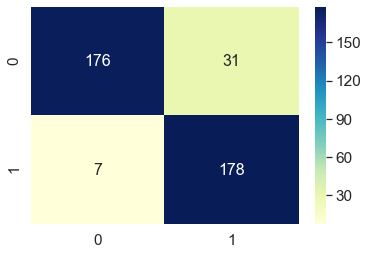

----------------------------------------------------------------------
Logistic Regression Accuracy(Test Set - 1st Principles): 0.9030612244897959
----------------------------------------------------------------------
Logistic Regression F1(Test Set - 1st Principles): 0.9035532994923857
----------------------------------------------------------------------
Logistic Regression Precision(Test Set - 1st Principles): 0.9621621621621622
----------------------------------------------------------------------
Logistic Regression Recall(Test Set - 1st Principles): 0.8516746411483254
----------------------------------------------------------------------


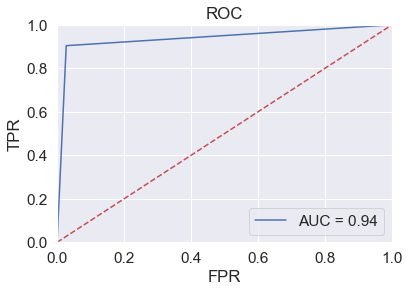

In [26]:
#Building the Confusion Matrix for the Test Set
final_test_prediction = sigmoid(np.dot(w, X_test.T) + c)
m_test =  X_test.shape[0]
y_test_pred = predict(final_test_prediction, m_test)

cm = confusion_matrix(y_test_pred.transpose(), y_test)
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt="d",  cmap="YlGnBu") # font size
plt.show()
print("----------------------------------------------------------------------")
print("Logistic Regression Accuracy(Test Set - 1st Principles):",accuracy_score(y_test, y_test_pred.transpose()))
print("----------------------------------------------------------------------")
print("Logistic Regression F1(Test Set - 1st Principles):",f1_score(y_test,  y_test_pred.transpose()))
print("----------------------------------------------------------------------")
print("Logistic Regression Precision(Test Set - 1st Principles):",precision_score(y_test,  y_test_pred.transpose()))
print("----------------------------------------------------------------------")
print("Logistic Regression Recall(Test Set - 1st Principles):",recall_score(y_test,  y_test_pred.transpose()))
print("----------------------------------------------------------------------")


fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'best')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [ ]:
def k_fold_cross_validation(df, folds):
#    Split dataset in k-fold parts
    origdf = df.reset_index(drop = True)
    train_test_split = list()
    foldsize = int(origdf.shape[0]/folds)
    indexes = origdf.index.values.tolist()
    for i in range(folds):
        thisfold = list()
        while len(thisfold) < foldsize:
            index = random.sample(indexes,1)
            thisfold.append(index[0])
            indexes.remove(index[0])      
        train_test_split.append(thisfold)
        
    return train_test_split

def optimise_model(original_df, folds, alpha, num_of_iter, iter_gap):
#    First there is the random split using the k-fold cross validation
    k_fold_split = k_fold_cross_validation(original_df, folds)
    training_fold = pd.DataFrame()
    testing_fold = pd.DataFrame()
    for i in range(0,len(k_fold_split)):
        
        
        all_k_fold_split = []
        k_fold_split = k_fold_cross_validation(original_df, folds)
        testing_fold.drop(testing_fold.index, inplace=True)
        training_fold.drop(testing_fold.index, inplace=True)
        print('Results for fold', i+1)
        
#       fold i will be used for testing and the other folds will be used for training
        testing_fold = original_df.iloc[k_fold_split[i]]
        del k_fold_split[i]
        
        for j in range(len(k_fold_split)):
            all_k_fold_split += k_fold_split[j]
            
        training_fold = original_df.iloc[all_k_fold_split]
        
        X_train = training_fold.iloc[:,:-1]
        y_train = np.asarray(training_fold.iloc[:,-1])
        X_test = testing_fold.iloc[:,:-1]
        y_test = np.asarray(testing_fold.iloc[:,-1])
        
        w,c = initial_weights(X_train.shape[1])
        end_param, costs, iter_gap = prediction_model(w, c, X_train, y_train, alpha, num_of_iter, iter_gap)
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (per {})'.format(iter_gap))
        plt.title('Cost reduction over time')
        plt.show()
        
        w = end_param["x-coefficients"]
        c = end_param["y-intercept"]

        final_train_prediction = sigmoid(np.dot(w, X_train.T)+ c)
        m_train = X_train.shape[0]
        y_train_pred = predict(final_train_prediction, m_train)
        final_test_prediction = sigmoid(np.dot(w, X_test.T) + c)
        m_test =  X_test.shape[0]
        y_test_pred = predict(final_test_prediction, m_test)
        
        cm = confusion_matrix(y_train_pred.transpose(), y_train)
        print(cm)
        print("----------------------------------------------------------------------")
        print("Logistic Regression Accuracy(Training Set - 1st Principles):",accuracy_score(y_train, y_train_pred.transpose()))
        print("Logistic Regression F1(Training Set - 1st Principles):",f1_score(y_train,  y_train_pred.transpose()))
        print("Logistic Regression Precision(Training Set - 1st Principles):",precision_score(y_train,  y_train_pred.transpose()))
        print("Logistic Regression Recall(Training Set - 1st Principles):",recall_score(y_train,  y_train_pred.transpose()))
        print("----------------------------------------------------------------------")

        cm_2 = confusion_matrix(y_test_pred.transpose(), y_test)
        sns.set(font_scale=1.4) # for label size
        sns.heatmap(cm_2, annot=True, annot_kws={"size": 16}, fmt="d",  cmap="YlGnBu") # font size
        plt.show()
        print("----------------------------------------------------------------------")
        print("Logistic Regression Accuracy(Test Set - 1st Principles):",accuracy_score(y_test, y_test_pred.transpose()))
        print("Logistic Regression F1(Test Set - 1st Principles):",f1_score(y_test,  y_test_pred.transpose()))
        print("Logistic Regression Precision(Test Set - 1st Principles):",precision_score(y_test,  y_test_pred.transpose()))
        print("Logistic Regression Recall(Test Set - 1st Principles):",recall_score(y_test,  y_test_pred.transpose()))
        print("----------------------------------------------------------------------")
        
        fpr, tpr, threshold = roc_curve(y_test, y_test_pred.transpose())
        roc_auc = auc(fpr, tpr)

        plt.title('ROC')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'best')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('TPR')
        plt.xlabel('FPR')
        plt.show()

    return testing_fold, training_fold 

In [ ]:
test, trg = optimise_model(new_df, 4, alpha = 0.05, num_of_iter = 40000, iter_gap = 5000)